<p style="text-align:center">
PSY 381D <b>Brain Connectivity</b>, Spring 2019


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/Banner.png?raw=true" alt="title pics"/>

</p>

<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> Brain atlases & node definition </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>March 11, 2019</b></p>

<hr style="height:5px;border:none" />

# 0. Docker issue
<hr style="height:1px;border:none" />

There is a minor issue with the Docker image `sathayas/python-fsl-bundle`. While I am working to correct the issue, you can run all the codes for today's material by simply running a couple of commands. After running this Docker image, at the prompt **`tmp#`**, run the following commands
* `apt-get install -y libopenblas-base`
* `export LD_LIBRARY_PATH=/usr/lib/openblas-base/`

Then you can start Jupyter notebook (or run IPython).

# 1. Data
<hr style="height:1px;border:none" />

All the files are available in the **`DataAtlas`** directory, available in either the note or code repository.

## fMRI data
In this exercise, we will be using this fMRI data:
* `Oxford_sub16112_func2standard_r_bp_reg_ms.nii.gz`

This file contains a series of 3D volumes from resting-state fMRI experiment. This data has been pre-processed (to be covered later in the semester). 

## Atlases
We will use two atlases for this exercise:
* `aal_MNI_V4.nii.gz`: AAL atlas
* `tcorr05_2level_all_r.nii.gz`: Rt2 atlas, or Craddock $r_t$ 2-level atlas, containing a series of atlases defined as different values of K

## NIfTI format
All image data for this exercise are in the NIfTI format. **NIfTI** stands for Neuroimaging Informatics Technology Initiative, with **`.nii`** extension, or compressed version with **`.nii.gz`** extension. A NIfTI file consists of the header information (first 348 Bytes) and the image data (the rest of the file).

### NIfTI header
A typical NIfTI header includes a number of fields describing information regarding the image.  Let's take a look at some examples.

`<HeaderInfo.py>`

In [1]:
%matplotlib inline

In [3]:
import numpy as np
import nibabel as nib



###### Image data files
# atlas data files
f_atlasAAL = 'DataAtlas/aal_MNI_V4.nii.gz'
f_atlasRt2 = 'DataAtlas/tcorr05_2level_all.nii.gz'

#fMRI data file (processed)
f_fMRI = 'DataAtlas/Oxford_sub16112_func2standard_r_bp_reg_ms.nii.gz'

The **`load`** function in the **`nibabel`** library allows you to create an NIfTI image object. You can get the header information with the **`.header`** method and the image data with the **`get_data`** method

In [4]:
##### Header information (fMRI)
# loading the fMRI data
fMRI = nib.load(f_fMRI)   # image object
hdr_fMRI = fMRI.header   # header information
X_fMRI = fMRI.get_data()  # image data array

Here is the full header for the fMRI data.

In [5]:
# priting out the header information
print(hdr_fMRI)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  46  56  42 172   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  4.  4.  4.  1.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-4.  0.  0. 90

As you can see, there is quite a bit of information. We only need some selected information from the header, such as the image dimension (number of voxels in x-, y-, and z-directions) as well as the number of time points.

In [6]:
# image dimension
print(hdr_fMRI.get_data_shape())

(46, 56, 42, 172)


And the voxel size (in mm, x-, y-, and z-directions) as well as the TR (in seconds, time between time points in fMRI experiment).

In [7]:
# voxel size
print(hdr_fMRI.get_zooms())

(4.0, 4.0, 4.0, 1.0)


Here is the header information (dimension and voxel size only) for the AAL atlas

In [8]:
##### Header information (AAL atlas)
# loading the AAL atlas data
AAL = nib.load(f_atlasAAL)   # image object
hdr_AAL = AAL.header   # header information
X_AAL = AAL.get_data()  # image data array

# image dimension
print(hdr_AAL.get_data_shape())

# voxel size
print(hdr_AAL.get_zooms())

(91, 109, 91, 1)
(2.0, 2.0, 2.0, 0.0)


### Exercise
* **Image dimension & voxel size, Rt2 atlas**. Determine the image dimension and the voxel size for the Rt2 atlas image. Post the code and the numbers on Canvas.

## Image data
After the header information, the rest of an NIfTI file contains image data as a series of voxel values. The **`get_data`** method can extract that information and put in a 4D (or 3D) array. Let's take a look at some image data.

`<ImageData.py>`

In [10]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


###### functions to display 3D image
def show_plane(x, nameCmap='gray'):
    '''
    Function to show a slice (provided as a 2D array)
    '''
    plt.imshow(x, cmap=nameCmap)
    plt.gca().set_axis_off()


def show_section(xImg, section, xSlice, nameCmap='gray'):
    '''
    Function to return a 2D array of a slice from a 3D array.
    Slice orientation can be specified by the user.
    '''
    if section=='xy':
        tmpImg = xImg[:,:,xSlice]
    elif section=='xz':
        tmpImg = xImg[:,xSlice,:]
    else:
        tmpImg = xImg[xSlice,:,:]
    show_plane(np.rot90(tmpImg),nameCmap)

###### Image data files
# atlas data files
f_atlasAAL = 'DataAtlas/aal_MNI_V4.nii.gz'
f_atlasRt2 = 'DataAtlas/tcorr05_2level_all.nii.gz'

#fMRI data file (processed)
f_fMRI = 'DataAtlas/Oxford_sub16112_func2standard_r_bp_reg_ms.nii.gz'

To facilitate visualization of the data, I have written a function called **`show_section`**. It takes a 3D array as first input parameter, followed by the slice specifier (xy-, xz-, or yz-slice) and the location of the slice (given as a single number). I am displaying the first 5 time points from the fMRI data as xy-slices (known as **axial** sections) at Z=20.

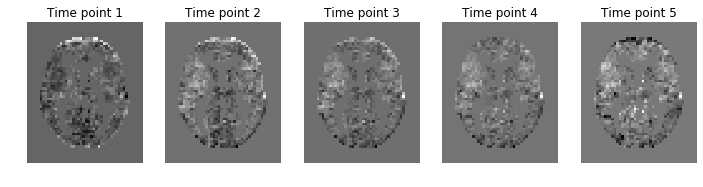

In [11]:
##### showing the image (fMRI)
# loading the fMRI data
fMRI = nib.load(f_fMRI)   # image object
hdr_fMRI = fMRI.header   # header information
X_fMRI = fMRI.get_data()  # image data array

# showing fMRI time series, first 5 time points
plt.figure(figsize=[12,3])

for iTime in range(5):
    plt.subplot(1,5,iTime+1)
    show_section(X_fMRI[:,:,:,iTime], 'xy', 20) # xy-section, at time=iTime
    plt.title('Time point ' + str(iTime+1))

plt.show()

Just for fun, I am plotting the voxel time course from one of the voxels ((x,y,z) = (13,20,20)).

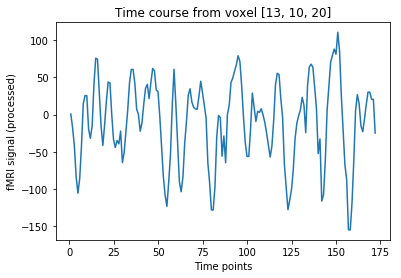

In [12]:
##### Showing the time course (fMRI)
# time course from a voxel
xVox = 13
yVox = 10
zVox = 20
timeVox = [X_fMRI[xVox,yVox,zVox,i] for i in range(X_fMRI.shape[-1])]
# plotting the time course
plt.plot(np.arange(1,len(timeVox)+1),timeVox)
plt.title('Time course from voxel ' + str([xVox,yVox,zVox]))
plt.xlabel('Time points')
plt.ylabel('fMRI signal (processed)')
plt.show()

Now let's take a look at the AAL atlas. In this case, I am showing an axial section at Z=38.

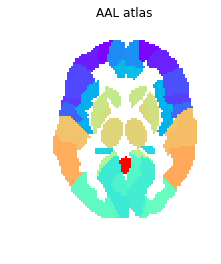

In [13]:
##### showing the atlas (AAL)
# loading the AAL atlas data
AAL = nib.load(f_atlasAAL)   # image object
hdr_AAL = AAL.header   # header information
X_AAL = AAL.get_data().astype(float)  # image data array

X_AAL[X_AAL==0] = np.nan  # suppressing the background
show_section(X_AAL[:,:,:,0], 'xy', 38, nameCmap='rainbow') 
plt.title('AAL atlas')
plt.show()

This is what a typical atlas image looks like. Voxels belonging to the same ROI (region of interest) are assigned a same integer value.

As for the Rt2 atlas, it contains a series of atlases with different values of K (for target number of clusters in the clustering algorithm).

In [15]:
##### showing the atlas (Rt2)
# loading the Rt2 atlas data
Rt2 = nib.load(f_atlasRt2)   # image object
hdr_Rt2 = Rt2.header   # header information
X_Rt2 = Rt2.get_data().astype(float)  # image data array

# Ks for clustering algorithm
K = list(range(10,301,10)) + list(range(350,1000,50))  

Here is a list of Ks included in this atlas.

In [17]:
print(K)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]


From these Ks, we select 5 different Ks.

In [18]:
subK = [50, 100, 200, 500, 950]   # Ks for example atlases
indK = [list(K).index(k) for k in subK]  # indices corresponding to subK

And we examine the atlas with different Ks.

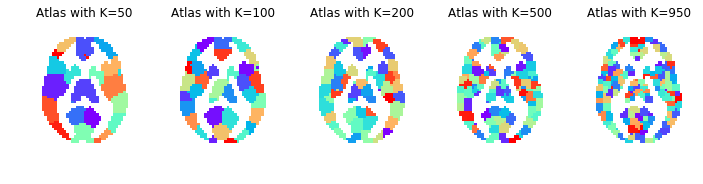

In [19]:
# showing the atlas with different Ks
X_Rt2[X_Rt2==0] = np.nan  # suppressing the background
plt.figure(figsize=[12,3])

for i,K in enumerate(subK):
    plt.subplot(1,5,i+1)
    show_section(X_Rt2[:,:,:,indK[i]], 'xy', 20, nameCmap='rainbow') 
    plt.title('Atlas with K=' + str(K))

plt.show()

As you can see, the larger K becomes, the smaller each ROI becomes.

# 2. Re-slicing atlases
<hr style="height:1px;border:none" />

Unless you construct your own atlas based on your fMRI data, chances are your atlas has a different dimension and voxel size from your fMRI data. To extract mean ROI time courses using an atlas, it would be a lot easier if the atlas and the fMRI data have the same dimension and voxel size. So a logical step is to re-slice the atlas to match the dimension / voxel size of the fMRI data.

I have written a wrapper function to call the **`flirt`** function in the FSL software to re-slice an atlas. 

`<ReslicingAtlas.py>`

In [43]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt


###### functions to display 3D image
def show_plane(x, nameCmap='gray'):
    '''
    Function to show a slice (provided as a 2D array)
    '''
    plt.imshow(x, cmap=nameCmap)
    plt.gca().set_axis_off()


def show_section(xImg, section, xSlice, nameCmap='gray'):
    '''
    Function to return a 2D array of a slice from a 3D array.
    Slice orientation can be specified by the user.
    '''
    if section=='xy':
        tmpImg = xImg[:,:,xSlice]
    elif section=='xz':
        tmpImg = xImg[:,xSlice,:]
    else:
        tmpImg = xImg[xSlice,:,:]
    show_plane(np.rot90(tmpImg),nameCmap)



####### function to reslice 4D image to a user-specified voxel size & dimension
def reslice_fmri(ffMRI, img_dim, vox_sz):
    '''a function to reslice the warped fMRI image to desired size.
    
    This function is necessary since warped fMRI has the same voxel size
    as the structural MRI. The resliced image is written with the same file
    name as the input file name with _r suffix attached at the end.
    
    Input parameters:
          ffMRI:        The file name of the 4D fMRI data to be resliced.
          img_dim:      A 3-element vector describing the number of voxles
                        in x, y, and z directions.
          vox_sz:       A 3-element vector describing the size of each voxel
                        in mm (x, y, and z sizes).
    
    Returns:
          NONE:
    '''

    # file name business first
    WorkDir, fImg = os.path.split(os.path.abspath(ffMRI))
    tmpfname, tmpext = os.path.splitext(fImg)
    if tmpext == '.gz':
        # the extension is .nii.gz
        tmpfname, tmpext = os.path.splitext(tmpfname)
    # the fake header name
    ffakehdr = os.path.join(WorkDir, tmpfname + '_r_tmp')
    # the output 4D fMRI data
    fout = os.path.join(WorkDir, tmpfname + '_r')
    # the identity matrix (a la fsl)
    DirFSL = os.environ['FSLDIR']
    feye = os.path.join(DirFSL, 'etc/flirtsch/ident.mat')

    # then putting together the command to create the fake header
    com_hdr = 'fslcreatehd '
    for iDim in img_dim:
        com_hdr += ' ' + str(iDim)
    com_hdr += ' 1'
    for iSize in vox_sz:
        com_hdr += ' ' + str(iSize)
    com_hdr += ' 1 0 0 0 16 ' + ffakehdr
    # creating the faek header
    res = os.system(com_hdr)

    # then putting together the command for flirt for reslicing
    com_flirt = 'flirt -in ' + ffMRI
    com_flirt += ' -applyxfm -init ' + feye
    com_flirt += ' -out ' + fout
    com_flirt += ' -paddingsize 0.0'
    com_flirt += ' -interp nearestneighbour'
    com_flirt += ' -ref ' + ffakehdr
    # then calling flirt
    res = os.system(com_flirt)

    # finally removing the fake header
    com_rm = 'rm ' + ffakehdr + '.nii.gz'
    res = os.system(com_rm)

So, first, extracting the dimension and voxel size from the fMRI data.

In [44]:
###### Image data files
# atlas data files
f_atlasAAL = 'DataAtlas/aal_MNI_V4.nii'
f_atlasRt2 = 'DataAtlas/tcorr05_2level_all.nii.gz'

#fMRI data file (processed)
f_fMRI = './DataAtlas/Oxford_sub16112_func2standard_r_bp_reg_ms.nii.gz'



##### extracting info from fMRI
# loading the fMRI data
fMRI = nib.load(f_fMRI)   # image object
hdr_fMRI = fMRI.header   # header information
dimfMRI = hdr_fMRI.get_data_shape()[:-1]  # xyz dimension in terms of  
sizefMRI = hdr_fMRI.get_zooms()[:-1]  # voxel size in mm in xyz directions

Then using that information to re-slice the atlas via the `reslice_fmri` (a custom function; see above).

In [45]:
##### reslicing the AAL atlas
reslice_fmri(f_atlasAAL, dimfMRI, sizefMRI)

##### reslicing the Rt2 atlas
reslice_fmri(f_atlasRt2, dimfMRI, sizefMRI)

Now quality control of re-slices atlases.

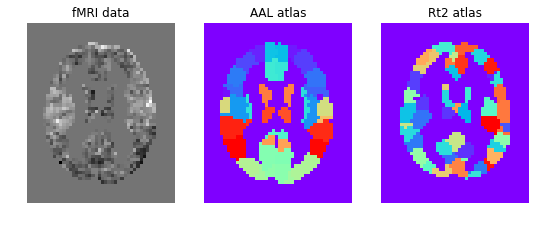

In [14]:
##### Quality control
f_atlasAAL_r = 'DataAtlas/aal_MNI_V4_r.nii.gz'
f_atlasRt2_r = 'DataAtlas/tcorr05_2level_all_r.nii.gz'
AAL = nib.load(f_atlasAAL_r)   # image object
Rt2 = nib.load(f_atlasRt2_r)   # image object

X_fMRI = fMRI.get_data()
X_AAL = AAL.get_data()
X_Rt2 = Rt2.get_data()


zSlice = 22
plt.figure(figsize=[9,4])

plt.subplot(131)
show_section(X_fMRI[:,:,:,1],'xy',zSlice)
plt.title('fMRI data')

plt.subplot(132)
show_section(X_AAL,'xy',zSlice, nameCmap='rainbow')
plt.title('AAL atlas')

plt.subplot(133)
show_section(X_Rt2[:,:,:,20],'xy',zSlice, nameCmap='rainbow')
plt.title('Rt2 atlas')

plt.show()

### Exercise
**Image dimension & voxel size, re-sliced atlases**. Determine the image dimension and the voxel size for re-sliced atlases (both AAL and Rt2). Post the code and the numbers on Canvas.


# 3. Forming a network
<hr style="height:1px;border:none" />

Now that the atlases have been re-sliced to the same size as the fMRI data, we are ready to construct networks. First, we extract mean time course from all ROIs defined in an atlas. Then we calculate a correlation matrix from the mean time course data. Finally we threshold the correlation matrix to generate an adjacency matrix describing a network.

## Extracting mean time course

From the fMRI time series data, the mean fMRI time series is extracted for each ROI defined in an atlas. I have written a custom function **`extract_roits`** to do that.

`<ExtractROITimeSeries.py>`

In [17]:
import os
import numpy as np
import nibabel as nib
import networkx as nx
import matplotlib.pyplot as plt

##### function to extract mean fMRI time series from ROIs 
def extract_roits(datafMRI, dataAtlas):
    '''
    A function to extract the average ROI time series from 4D fMRI
    data.
    input parameters:
          datafMRI: The 4D array of the fMRI image. The fMRI data should
                    have already been normalized and preprocessed.
          dataAtlas:The 3D array of the atlas image defining different ROIs.
                    The atlas image is assumed to be in the same space as the 
                    fMRI data. In other words, it needs to be re-sliced to 
                    the fMRI data voxel size beforehand.
    returns:
          roi_ts:   An array of the extracted time series. Rows correspond to
                    time points, the columns corresponds to ROIs. The ROIs are
                    in the same order as roi_ind.
          roi_ind:  A vector of ROI numbers, in the same order as the columns
                    of the roi_ts.
    '''

    # nan-ing the fMRI data -- voxel-value = zero is replaced with nan
    datafMRI[datafMRI==0] = np.nan

    # creating the roi indices
    roiMin = np.min(np.unique(dataAtlas[dataAtlas>0]))
    roiMax = np.max(np.unique(dataAtlas[dataAtlas>0]))
    roi_ind = np.arange(roiMin, roiMax+1)
    
    # preparing the output time series array
    nTime = datafMRI.shape[-1]
    roi_ts = np.zeros([nTime, len(roi_ind)])

    # for loop to calculate the time series
    for iTime in range(nTime):
        tmpfMRI = datafMRI[:,:,:,iTime]
        for i,iROI in enumerate(roi_ind):
            tmpROIdata = tmpfMRI[dataAtlas==iROI]
            if len(tmpROIdata)> 0 and not all(np.isnan(tmpROIdata)):
                roi_ts[iTime, i] = np.nanmean(tmpROIdata)

    # removing colums with any nan
    removeInd = []   # indices of columns to be removed
    for iCol in range(roi_ts.shape[1]):
        if all(roi_ts[:,iCol]==0):
            removeInd.append(iCol)
    roi_ts = np.delete(roi_ts, removeInd, 1)
    roi_ind= np.delete(roi_ind, removeInd)

    # returning the results
    return roi_ts, roi_ind


###### function to extract mean ROI coordinates for future plotting
def roi_coord(dataAtlas, nodeList):
    xyzROI = []
    for iNode in nodeList:
        ROIvoxels = np.mean(np.where(dataAtlas==iNode), axis=1)
        xyzROI.append(list(ROIvoxels))
    return np.array(xyzROI)

In [18]:
###### Image data files
# atlas data files (resliced version)
f_atlasAAL = 'DataAtlas/aal_MNI_V4_r.nii.gz'
f_atlasRt2 = 'DataAtlas/tcorr05_2level_all_r.nii.gz'
X_AAL = nib.load(f_atlasAAL).get_data()
X_Rt2 = nib.load(f_atlasRt2).get_data()


#fMRI data file (pre-processed)
f_fMRI = 'DataAtlas/Oxford_sub16112_func2standard_r_bp_reg_ms.nii.gz'
X_fMRI = nib.load(f_fMRI).get_data()

Here, the extracted time series data, as well as a list of valid nodes are returned from the **`extract_roits`** function. A valid node means that that node includes fMRI time series data from brain voxel(s). In addition to extracting the time series, I am also calculating the xyz-coordinates for all ROIs using another custom function **`roi_coord`**. 

In [19]:
###### Extracting time series (AAL)
ts_AAL, node_AAL = extract_roits(X_fMRI, X_AAL)
xyz_AAL = roi_coord(X_AAL, node_AAL)

Just for fun, here is what the extracted time series data look like:

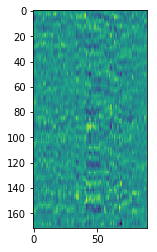

In [20]:
plt.imshow(ts_AAL)
plt.show()

We will save these arrays to a file for future use, by using **`savez`** function from NumPy.

In [21]:
# saving for later use
np.savez('DataAtlas/Oxford_sub16112_aal_ts.npz',
         ts = ts_AAL,
         nodes = node_AAL,
         xyz = xyz_AAL)

And we extract mean ROI time series data with the Rt2 atlas, at selected values of K.

In [22]:
###### Extracting time series (Rt2)
# Ks for clustering algorithm
K = list(range(10,301,10)) + list(range(350,1000,50))  
subK = [50, 100, 200, 500, 950]   # Ks for example atlases
indK = [list(K).index(k) for k in subK]  # indices corresponding to subK

# actual time series extraction (Rt2)
for i,targetK in enumerate(subK):
    ts_Rt2, node_Rt2 = extract_roits(X_fMRI, 
                                     X_Rt2[:,:,:,indK[i]])
    xyz_Rt2 = roi_coord(X_Rt2[:,:,:,indK[i]], 
                        node_Rt2)

    # saving for later use
    np.savez('DataAtlas/Oxford_sub16112_rt2_K' + str(targetK) +'.npz',
             ts = ts_Rt2,
             nodes = node_Rt2,
             xyz = xyz_Rt2)

## Calculating correlation matrix

Unless you are mathematically savvy, most people use correlation coefficients to describe functional connectivity between two nodes (or two ROI time courses in this case). This can be done easily with **`np.corrcoef`** function in NumPy. First, AAL network


`<ConstructNetwork.py>`

In [24]:
import os
import numpy as np
import nibabel as nib
import networkx as nx
import matplotlib.pyplot as plt

###### Parameters
targetDeg = 10  # target average degree

############### Network according to AAL #################

###### Loadin the data from the previous time
f_TS = 'DataAtlas/Oxford_sub16112_aal_ts.npz'
infile = np.load(f_TS)
ts = infile['ts']
nodes = infile['nodes']
xyz = infile['xyz']

So the time series data have been loaded from a file, and we calculate the correlation matrix.

In [25]:
###### Calculating the correlation matrix
R = np.corrcoef(ts, rowvar=False)

This is what the resulting correlation matrix looks like. Notice that the main diagonal is 1 (correlation to itself). 

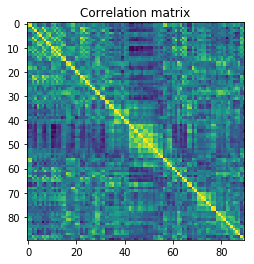

In [26]:
# showing the correlation coefficient
plt.imshow(R)
plt.title('Correlation matrix')
plt.show()

When thresholded, these 1s form self-loops. In order to avoid that, we set the main diagonal elements to 0. Here is the updated correlation matrix.

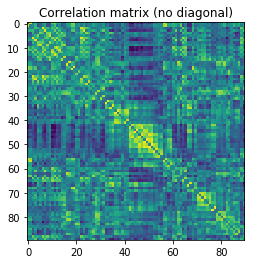

In [27]:
# making the diagonal elements to zero
for iRow in range(R.shape[0]):
    R[iRow,iRow] = 0

# showing the correlation coefficient
plt.imshow(R)
plt.title('Correlation matrix (no diagonal)')
plt.show()

## Thresholding

The next step is to threshold this correlation matrix to generate a binary adjacency matrix. This is done by applying a single threshold to the correlation matrix (known as hard thresholding) to form a binary matrix. The threshold is adjusted in a way
* To control FDR (false discovery rate)
* To control the edge density (number of edges divided by the number of all possible edges)
* To control the average degree

We will try the third approach.

It is also possible to apply a threshold at each row of the correlation matrix separately. In this approach (node-wise thresholding), only the d largest correlation coefficients are chosen in each row to form a network.

I have written custom functions to implement both thresholding methods (**`net_builder_HardTh`** and **`net_builder_RankTh`**, respectively).

In [29]:
###### Network construction functions, based on correlation matrix

def net_builder_RankTh(R, NodeInd, d, cType=1):
    '''
    a function to construct the network by the rank-based thresholding
     
    input parameters:
          R:         A dense correlation matrix array.
          NodeInd:   A list of nodes in the network.
          d:         The rank threshold for the rank-based thresholding.
          cType:     Type of functional connectivity. 
                        1:  Positive correlation only
                        0:  Both positive and negative correlations
                        -1: Negative correlation only
                     The default is 1 (i.e., positive correlation only).
    returns:
          G:         The resulting graph (networkX format)
    '''

    # first, initialize the graph
    G = nx.Graph()
    G.add_nodes_from(NodeInd)
    NNodes = R.shape[0]
    # the working copy of R, depending on the connectivity type
    if cType==1:
        WorkR = np.copy(R)
    elif cType==0:
        WorkR = abs(np.copy(R))
    elif cType==-1:
        WorkR = np.copy(-R)
    # then add edges
    for iRank in range(d):
        I = np.arange(NNodes)
        J = np.argmax(WorkR, axis=1)
        # R has to be non-zero
        trI = [i for i in range(NNodes) if WorkR[i, J[i]]>0]
        trJ = [J[i] for i in range(NNodes) if WorkR[i, J[i]]>0]
        # adding connections (for R>0)
        Elist = np.vstack((NodeInd[trI], NodeInd[trJ])).T 
        G.add_edges_from(Elist)
        WorkR[trI, trJ] = 0  # clearing the correlation matrix
    # finally returning the resultant graph
    return G



def net_builder_HardTh(R, NodeInd, K, cType=1):
    '''
    a function to construct the network by the hard-thresholding.
    input parameters:
          R:         A dense correlation matrix array.
          NodeInd:   A list of nodes in the network.
          K:         The target K, the average connections at each node
          cType:     Type of functional connectivity. 
                        1:  Positive correlation only
                        0:  Both positive and negative correlations
                        -1: Negative correlation only
                     The default is 1 (i.e., positive correlation only).
    
    returns:
          G:         The resulting graph (networkX format)
    '''
    
    # first, initialize the graph
    G = nx.Graph()
    G.add_nodes_from(NodeInd)
    NNodes = R.shape[0]
    # upper triangle of the correlation matrix only
    I,J = np.triu_indices(NNodes,1)
    # creating a vector of correlation coefficients, depending on cType
    if cType==1:
        VecR = np.squeeze(np.array(R[I,J]))
    elif cType==0:
        VecR = np.squeeze(np.array(abs(R[I,J])))
    elif cType==-1:
        VecR = np.squeeze(np.array(-R[I,J]))
    # the number of elements is too big, so we truncate it
    # first, find the appropriate threshold for R
    NthR = 0
    tmpRth = 0.95
    StepTh = 0.05
    while NthR<K*NNodes/2.0:
        tmpRth -= StepTh
        #print('Threshold = %.2f' % tmpRth)
        NthR = len(np.nonzero(VecR>tmpRth)[0])
    # second, truncate the variables
    IndVecR = np.nonzero(VecR>tmpRth)
    thVecR = VecR[IndVecR]
    thI = I[IndVecR]
    thJ = J[IndVecR]
    # sort the correlation values
    zipR = zip(thVecR, thI, thJ)
    zipsR = sorted(zipR, key = lambda t: t[0], reverse=True)
    sVecR, sI, sJ = zip(*zipsR)
    # then adding edges
    m = int(np.ceil(K*NNodes/2.0))  # the number of edges
    trI = np.array(sI[:m])
    trJ = np.array(sJ[:m])
    Elist = np.vstack((NodeInd[trI], NodeInd[trJ])).T
    G.add_edges_from(Elist)
    RTh = sVecR[m-1]  # the threshold
    # finally returning the resultant graph and the threshold
    return G

For hard thresholding, the target average degree is 10. For node-wise thresholding, the target d is 7.

In [30]:
###### Thresholding
# hard thresholding -- with user-defined target degree
targetDeg = 10  # target average degree
G_degree = net_builder_HardTh(R, nodes, targetDeg)
# rank thresholding -- with user-defined d
target_d = 7
G_rank = net_builder_RankTh(R, nodes, target_d)

Now let's visualize both networks.

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


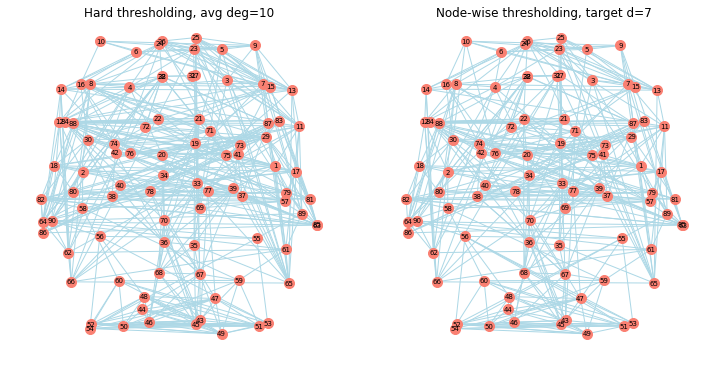

In [31]:
###### visualizing the network
# dictionary of xy-coordinates
pos = {}
for i in range(len(nodes)):
    pos[nodes[i]] = xyz[i,:2]

# first, hard-thresholding network
plt.figure(figsize=[12,6])
plt.subplot(121)
nx.draw_networkx_nodes(G_degree, pos, node_color='salmon',
                       node_size=100)
nx.draw_networkx_edges(G_degree, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_degree, pos, font_size=7, font_color='black')
plt.title('Hard thresholding, avg deg=' + str(targetDeg))
plt.axis('off')

# second, rank-thresholding network
plt.subplot(122)
nx.draw_networkx_nodes(G_rank, pos, node_color='salmon',
                       node_size=100)
nx.draw_networkx_edges(G_rank, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_rank, pos, font_size=7, font_color='black')
plt.title('Node-wise thresholding, target d=' + str(target_d))
plt.axis('off')

plt.show()

We save these networks as files to be used later, using the **`write_adjlist`** function in networkX.

In [32]:
###### saving the network data for future use
nx.write_adjlist(G_degree,
                 'DataAtlas/Oxford_sub16112_aal_deg10.adjlist')
nx.write_adjlist(G_rank,
                 'DataAtlas/Oxford_sub16112_aal_d7.adjlist')

We will repeat the process of correlation calculation and thresholding with the Rt2 atlas too, with selected values of K. 

In [33]:
############### Network according to Rt2 #################

# Ks for clustering algorithm
K = list(range(10,301,10)) + list(range(350,1000,50))  
subK = [50, 100, 200, 500, 950]   # Ks for example atlases
indK = [list(K).index(k) for k in subK]  # indices corresponding to subK

###### Loop over K for constructing networks
G_degree = []
nodes_degree = []
xyz_degree = []
for i,targetK in enumerate(subK):

    ###### Loadin the data from the previous time
    f_TS = 'DataAtlas/Oxford_sub16112_Rt2_K' + str(targetK) + '.npz'
    infile = np.load(f_TS)
    ts = infile['ts']
    nodes = infile['nodes']
    xyz = infile['xyz']


    ###### Calculating the correlation matrix
    R = np.corrcoef(ts, rowvar=False)
    
    # making the diagonal elements to zero
    for iRow in range(R.shape[0]):
        R[iRow,iRow] = 0
        

    ###### Thresholding
    # hard thresholding -- with user-defined target degree
    G = net_builder_HardTh(R, nodes, targetDeg)
    # keeping the results for later
    G_degree.append(G)
    nodes_degree.append(nodes)
    xyz_degree.append(xyz)

    ###### writing network to a file
    fNet = 'DataAtlas/Oxford_sub16112_Rt2_K' + str(targetK)
    fNet += '_deg' + str(targetDeg) + '.adjlist'
    nx.write_adjlist(G, fNet)

And network visualization.

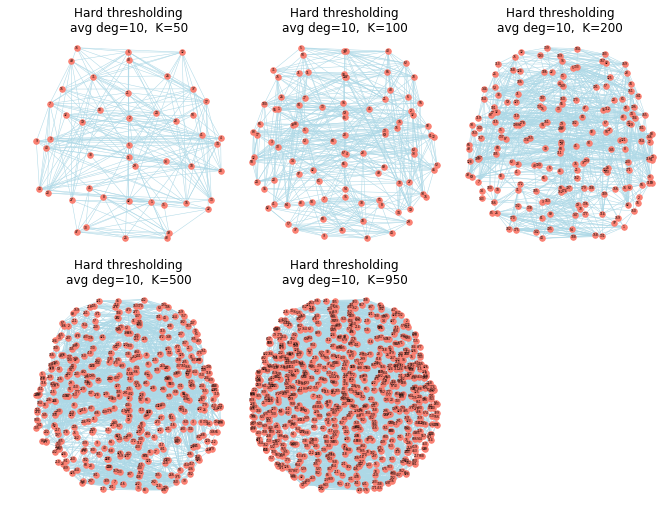

In [34]:
###### visualizing the networks
# Loop over K for visualization
plt.figure(figsize=[9,7.5])
for i,targetK in enumerate(subK):

    # dictionary of xy-coordinates
    pos = {}
    for iROI in range(len(nodes_degree[i])):
        pos[nodes_degree[i][iROI]] = xyz_degree[i][iROI,:2]

    # first, hard-thresholding network
    plt.subplot(2,3,i+1)
    nx.draw_networkx_nodes(G_degree[i], pos, node_color='salmon',
                           node_size=30)
    nx.draw_networkx_edges(G_degree[i], pos, width=0.5,
                           edge_color='lightblue')
    nx.draw_networkx_labels(G_degree[i], pos, font_size=3, font_color='black')
    plt.title('Hard thresholding\navg deg=' + str(targetDeg) +
              ',  K=' + str(targetK))
    plt.axis('off')
    
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.06, bottom=0.025)
plt.show()

# 4. Network characteristics
<hr style="height:1px;border:none" />

Now we have formed networks with different numbers of nodes with different values of K on the Rt2 atlas, we shall examine how the network size influences some network characteristics.

## Small-world measures

We shall see how the network size influences the clustering coefficient C and the path length L

`<SmallWorldness.py>`

In [37]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


###### Parameters
targetDeg = 10  # target average degree



###### Loading network data and calculate small-worldness stats
# Ks for clustering algorithm
K = list(range(10,301,10)) + list(range(350,1000,50))  
subK = [50, 100, 200, 500, 950]   # Ks for example atlases
indK = [list(K).index(k) for k in subK]  # indices corresponding to subK

G_list = []
N_list = []
C_list = []
L_list = []
for i,targetK in enumerate(subK):
    ###### file name, then loading
    fNet = 'DataAtlas/Oxford_sub16112_Rt2_K' + str(targetK)
    fNet += '_deg' + str(targetDeg) + '.adjlist'
    G = nx.read_adjlist(fNet, nodetype=int)
    G_list.append(G)

    ###### number of nodes
    N_list.append(len(G.nodes()))

    ##### clistering coefficient
    C_list.append(nx.average_clustering(G))

    ##### path length, giant component only
    GC_nodes = max(nx.connected_components(G), key=len)  
    GC = G.subgraph(GC_nodes)  
    L_list.append(nx.average_shortest_path_length(GC))

We load the networks we saved earlier, and calculate C and L, as well as the number of nodes N. Here are plots showing the relationship between the network size K and these metrics.

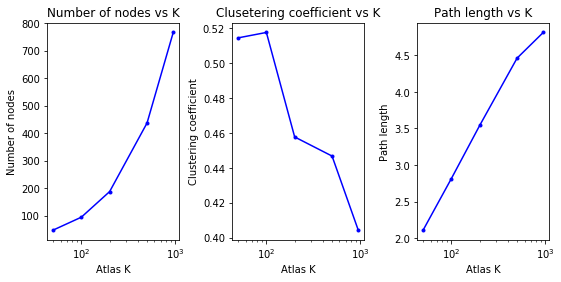

In [38]:
###### Plotting C and L
plt.figure(figsize=[9,4])

plt.subplot(131)
plt.plot(subK,N_list,'b.-')
plt.xscale('log')
plt.xlabel('Atlas K')
plt.ylabel('Number of nodes')
plt.title('Number of nodes vs K')

plt.subplot(132)
plt.plot(subK,C_list,'b.-')
plt.xscale('log')
plt.xlabel('Atlas K')
plt.ylabel('Clustering coefficient')
plt.title('Clusetering coefficient vs K')

plt.subplot(133)
plt.plot(subK,L_list,'b.-')
plt.xscale('log')
plt.xlabel('Atlas K')
plt.ylabel('Path length')
plt.title('Path length vs K')

plt.subplots_adjust(wspace=0.4)
plt.show()

As you can see, these measures appear influenced by the size of the network.

## Modular organization

If there are more nodes in a network, does that mean there will be more modules in that network? We answer this question by examining the modular organization at different network sizes. 

`<Modules.py>`

In [40]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community   # Louvain method


##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)



###### Parameters
targetDeg = 10  # target average degree



###### Loading network data and estimage modular partition by Louvain
# Ks for clustering algorithm
K = list(range(10,301,10)) + list(range(350,1000,50))  
subK = [50, 100, 200, 500, 950]   # Ks for example atlases
indK = [list(K).index(k) for k in subK]  # indices corresponding to subK

GC_list = []
nodes_list = []
xyz_list = []
partition_list = []
Q_list = []
for i,targetK in enumerate(subK):
    ###### file name, then loading network
    fNet = 'DataAtlas/Oxford_sub16112_Rt2_K' + str(targetK)
    fNet += '_deg' + str(targetDeg) + '.adjlist'
    G = nx.read_adjlist(fNet, nodetype=int)
    GC_nodes = max(nx.connected_components(G), key=len)  
    GC = G.subgraph(GC_nodes)  
    GC_list.append(GC)    

    ###### loading nodal info
    fTS = 'DataAtlas/Oxford_sub16112_rt2_K' + str(targetK) + '.npz'
    infile = np.load(fTS)
    nodes_full = infile['nodes']
    xyz_full = infile['xyz']
    nodes = []
    xyz = []
    for iNode in GC.nodes():
        indNode = np.where(nodes_full==iNode)[0]
        nodes.append(iNode)
        xyz.append(list(xyz_full[np.squeeze(indNode),:]))
    nodes_list.append(nodes)
    xyz_list.append(np.array(xyz))

    ###### modular partition by Louvain
    partition = community.best_partition(GC)
    partition_list.append(partition)
    Q_list.append(community.modularity(partition, GC))

    

I used the Louvain method for modular partition. Here is a plot of resulting modularity plotted against the network size K.

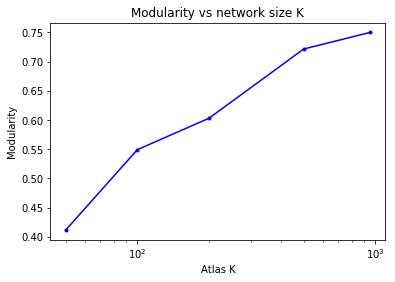

In [41]:
###### Plotting modularity vs network size
plt.plot(subK,Q_list,'b.-')
plt.xscale('log')
plt.xlabel('Atlas K')
plt.ylabel('Modularity')
plt.title('Modularity vs network size K')
plt.show()

It seems like larger networks are more modular. This makes sense due to availability of more nodes. Let's visualize modular partitions as well. 

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


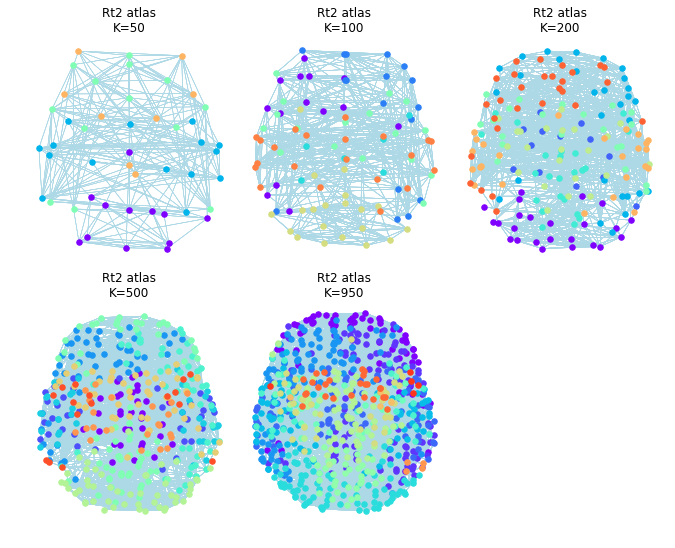

In [42]:
###### drawing the graph 
# Loop over K for visualization
plt.figure(figsize=[9,7.5])
for i,targetK in enumerate(subK):
    
    # dictionary of xy-coordinates
    pos = {}
    for iROI in range(len(nodes_list[i])):
        pos[nodes_list[i][iROI]] = xyz_list[i][iROI,:2]


    # finally, graph with communities in different colors (Louvain)
    plt.subplot(2,3,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    node_color_list = get_cmap(nComm+1,'rainbow')
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        nx.draw_networkx_nodes(GC_list[i], pos, 
                               nodelist=nodeList,
                               node_color = np.array([node_color_list(iComm)]),
                               node_size=30)
        nx.draw_networkx_edges(GC_list[i], pos, width=0.5,
                               edge_color='lightblue')
    plt.title('Rt2 atlas\n' + 'K=' + str(targetK))
    plt.axis('off')
    
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.925)
plt.show()

As you can see, some modules seem consistent across network sizes. 

# 5. Take-home message
<hr style="height:1px;border:none" />

* More nodes you have, you can explain subtleties in network organization
* A larger network requires more computational power.
   * Craddock et al., suggest K=200. That is a great happy median.
* Comparing networks of different sizes is notoriously hard! When compare networks across subjects, form the network using the same atlas. 
* AAL atlas is perhaps the most widely used atlas. However it is based on anatomical boundaries as opposed to functional boundaries.


# *Further readings*
<hr style="height:1px;border:none" />

* Hayasaka 2012. Anti-Fragmentation of Resting-State fMRI Connectivity Networks with Node-Wise Thresholding. Brain Connectivity 7: 504-514.
* Power et al. 2011. Functional Network Organization of the Human Brain. Neuron 72:665-678.
* Wang et al. 2009. Parcellation- dependent small-world brain functional networks: A resting-state fMRI study. Hum Brain Mapp 30(5):1511-23.